In [1]:
#载入必要的包

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



from keras.utils import np_utils, plot_model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding, Dropout
from sklearn.model_selection import train_test_split




D:\Users\Anaconda3\envs\DL_interview\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# 设置matplotlib绘图时的字体
from matplotlib import font_manager

my_font=font_manager.FontProperties(fname="/Library/Fonts/Songti.ttc")


In [3]:
# In[ ]: 读入数据
data=pd.read_csv("data.csv")
#查看数据
print(data.head())

                                          evaluation label
0                                    用了一段时间，感觉还不错，可以    正面
1  电视非常好，已经是家里的第二台了。第一天下单，第二天就到本地了，可是物流的人说车坏了，一直催...    正面
2                  电视比想象中的大好多，画面也很清晰，系统很智能，更多功能还在摸索中    正面
3                                                 不错    正面
4     用了这么多天了，感觉还不错。夏普的牌子还是比较可靠。希望以后比较耐用，现在是考量质量的时候。    正面


In [4]:
# In[ ]:查看有多少种评价

print(data.groupby("label")["label"].count())


label
正面    1908
负面    2375
Name: label, dtype: int64


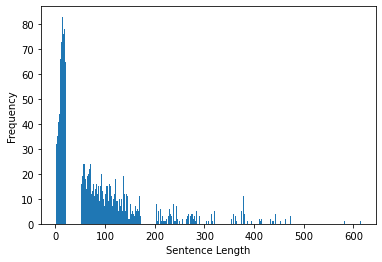

In [5]:
# 统计句子长度及长度出现的频数

data["length"]=data["evaluation"].apply(lambda x:len(x))
len_data=data.groupby("length").count()
length=len_data.index.tolist()
freq=len_data["evaluation"].tolist()
plt.bar(length,freq)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()



In [6]:
# 标签及词汇表
labels, vocabulary = list(data["label"].unique()),list(data["evaluation"].unique())
# 构造字符级别的特征

string=""
for word in vocabulary:
    string+=word
    
vocabulary=set(string)

print(vocabulary)




{'圈', '变', '拉', '忒', '围', '催', '泛', '迹', '打', '玻', '垂', '爱', '喜', '呐', '⑧', '扳', '谈', '先', '页', '皆', '徘', '两', '嘴', '低', '吗', '扔', '神', '附', '二', '湿', '。', '起', '章', '疵', '储', '仙', '，', '箱', '临', '凡', '善', '封', '会', '继', '担', '疑', '購', '腰', '宝', '0', '板', '\uf62c', '着', '慧', '拿', '岗', '矮', '兜', '午', '鸟', '射', '喊', '紫', '急', '）', '鉴', '省', '改', '慨', '念', '像', '支', '胜', '素', '地', '服', '叉', '狡', '造', '牌', '布', '半', '調', '苏', '即', '简', '册', '罢', '够', '忽', '甚', '助', '阿', '辩', '瀑', 'e', '丑', '葱', '脑', '悟', '融', '陈', '赖', '統', '挑', '梯', '=', '樱', '贩', '原', '拨', '订', '錯', '勒', '从', '土', '狐', '右', '语', '遗', 'i', '柄', '乌', '中', '凭', '纯', '撑', '"', '泰', '巧', '断', '官', '碰', '律', '编', '瓦', '绿', '框', '佰', '野', '海', '－', '道', '爸', '钉', '才', '压', '走', '喷', '诉', '屌', '蒙', '横', '多', '确', 'v', '弱', '且', '哭', 'f', '预', '委', '绚', '物', '查', '跑', '截', '停', '伤', '栏', '做', '脸', '靠', '丽', '彰', '威', 'N', '承', '拍', '喳', '皮', '竟', '守', '荒', '刺', '舞', '耽', '肯', '告', '眼', '健', '铺', '②', '单', '商', '风', '樣', '湾', '杭',

In [7]:
print(len(vocabulary))

2154


In [9]:
# 制作字典列表，用在人机交互
word_dictionary={word:i+1 for i ,word in enumerate(vocabulary)}


inverse_word_dictionary={i+1:word for i ,word in enumerate(vocabulary)}

print(inverse_word_dictionary)



{1: '圈', 2: '变', 3: '拉', 4: '忒', 5: '围', 6: '催', 7: '泛', 8: '迹', 9: '打', 10: '玻', 11: '垂', 12: '爱', 13: '喜', 14: '呐', 15: '⑧', 16: '扳', 17: '谈', 18: '先', 19: '页', 20: '皆', 21: '徘', 22: '两', 23: '嘴', 24: '低', 25: '吗', 26: '扔', 27: '神', 28: '附', 29: '二', 30: '湿', 31: '。', 32: '起', 33: '章', 34: '疵', 35: '储', 36: '仙', 37: '，', 38: '箱', 39: '临', 40: '凡', 41: '善', 42: '封', 43: '会', 44: '继', 45: '担', 46: '疑', 47: '購', 48: '腰', 49: '宝', 50: '0', 51: '板', 52: '\uf62c', 53: '着', 54: '慧', 55: '拿', 56: '岗', 57: '矮', 58: '兜', 59: '午', 60: '鸟', 61: '射', 62: '喊', 63: '紫', 64: '急', 65: '）', 66: '鉴', 67: '省', 68: '改', 69: '慨', 70: '念', 71: '像', 72: '支', 73: '胜', 74: '素', 75: '地', 76: '服', 77: '叉', 78: '狡', 79: '造', 80: '牌', 81: '布', 82: '半', 83: '調', 84: '苏', 85: '即', 86: '简', 87: '册', 88: '罢', 89: '够', 90: '忽', 91: '甚', 92: '助', 93: '阿', 94: '辩', 95: '瀑', 96: 'e', 97: '丑', 98: '葱', 99: '脑', 100: '悟', 101: '融', 102: '陈', 103: '赖', 104: '統', 105: '挑', 106: '梯', 107: '=', 108: '樱', 109: '贩', 110: '原', 11

In [12]:
# 查看词汇表大小和标签类别数量
label_dictionary={label:i for i, label in enumerate(labels)}

output_dictionary={i:label for i, label in enumerate(labels)}

print(label_dictionary)
print(output_dictionary)


{'正面': 0, '负面': 1}
{0: '正面', 1: '负面'}


In [13]:
vocab_size=len(word_dictionary.keys())
label_size=len(label_dictionary.keys())
print(vocab_size)
print(label_size)


2154
2


In [15]:
#制作训练输入和训练标签
#对于训练输入要进行序列填充，按input_shape填充，长度不足的按0补充

x=[[word_dictionary[word] for word in sent] for sent in data["evaluation"]]

x=pad_sequences(maxlen=180, truncating="pre", sequences=x,padding="post",value=0)

print(x.shape)






(4283, 180)


In [16]:
print(x)

[[ 498 1235 1455 ...    0    0    0]
 [ 752 1014 1292 ...    0    0    0]
 [ 752 1014 1266 ...    0    0    0]
 ...
 [1455 1517  513 ...    0    0    0]
 [2001  752 1014 ...    0    0    0]
 [1455  671  671 ...    0    0    0]]


In [17]:
#对于训练目标进行ONE-HOT-CODING

y=[[label_dictionary[sent]]for sent in data["label"]]
y=[np_utils.to_categorical(label,num_classes=label_size) for label in y]
y=np.array([list(_[0]) for _ in y])

print(y.shape)






(4283, 2)


In [18]:
# 拆分训练集和测试集

train_x, test_x, train_y, test_y=train_test_split(x,y,test_size=0.1)






In [20]:
#搭建模型
model=Sequential()
model.add(Embedding(input_dim=vocab_size+1,output_dim=20,input_length=180,mask_zero=True))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(label_size,activation="softmax"))
model.summary()
    



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 180, 20)           43100     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               48400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 91,702
Trainable params: 91,702
Non-trainable params: 0
_________________________________________________________________


In [21]:
#编译模型

model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [22]:
#训练模型
model.fit(train_x,train_y,epochs=5,batch_size=32,validation_data=(test_x,test_y))


Instructions for updating:
Use tf.cast instead.
Train on 3854 samples, validate on 429 samples
Epoch 1/5
3854/3854 [==============================] - 30s 8ms/step - loss: 0.4905 - acc: 0.7883 - val_loss: 0.3278 - val_acc: 0.9207
Epoch 2/5
3854/3854 [==============================] - 28s 7ms/step - loss: 0.2333 - acc: 0.9222 - val_loss: 0.2370 - val_acc: 0.9301
Epoch 3/5
3854/3854 [==============================] - 27s 7ms/step - loss: 0.1799 - acc: 0.9419 - val_loss: 0.2260 - val_acc: 0.9277
Epoch 4/5
3854/3854 [==============================] - 27s 7ms/step - loss: 0.1507 - acc: 0.9538 - val_loss: 0.1913 - val_acc: 0.9347
Epoch 5/5
3854/3854 [==============================] - 29s 7ms/step - loss: 0.1305 - acc: 0.9608 - val_loss: 0.2005 - val_acc: 0.9464


In [27]:
#测试新的评论
sent="真棒"

temp_x=[[word_dictionary[word] for word in sent]]
temp_x=pad_sequences(maxlen=180,sequences=temp_x,padding="post",value=0)

print(temp_x)
# 模型预测

y_predict=model.predict(temp_x)
print(output_dictionary[np.argmax(y_predict)])




[[ 491 1028    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
正面
